In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install -q transformers
import transformers 
from transformers import GPT2Model, GPT2Tokenizer 
from transformers import TextGenerationPipeline, AutoTokenizer, AutoModelForCausalLM 
from transformers import MegatronBertConfig, MegatronBertModel, BertTokenizer 

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import copy
import json

# Models

* GPT2-XL 1.5B(Decoder-only)
* Pangu $\alpha$ 2.6B: [Intro from Huawei](https://www.huaweicloud.com/product/modelarts/pangu.html) 
* erlangshen 1.3B: [Intro from IDEA](https://huggingface.co/IDEA-CCNL/Erlangshen-MegatronBert-1.3B)

# Visualization & Sparsification


In [9]:
def get_params_plot(model, model_name, sparsity=0):
  # get params dist.
  fig, ax = plt.subplots(figsize=(12,8))
  total_param = torch.cat([params.flatten() for params in model.parameters()]).detach().numpy()
  hist, bins = np.histogram(total_param, bins = np.linspace(-1,1,201)) 
  ax.plot(bins[:-1],hist) 
  plt.title("distribution of all weights(model:{}, sparsity:{}%)".format(model_name, sparsity*100), fontsize=25)
  plt.xlabel("Weight values")
  plt.ylabel("Log Count")
  plt.yscale('log')
  plt.show()
  plt.savefig('{}/figs/vis_all_params_{}_sparsity_{}%.png'.format(os.getcwd(), model_name, sparsity))

  if model_name == 'pangu':
    for child in model.named_children():
      if child[0] == 'transformer':
        model = child[1]
  
  if model_name == 'erlangshen':
    for child in model.named_children():
      if child[0] == 'encoder':
        model = child[1]
  
  # get params dist. in each layer
  for elem in model.named_children():
    if elem[0] == 'h' or elem[0] == 'layer': # erlangshen model uses layer as attr name ...
      fig, ax = plt.subplots(figsize=(12,8))
      for idx, child in enumerate(elem[1].named_children()):
        layer_param = torch.cat([params.flatten() for params in child[1].parameters()]).detach().numpy()
        hist, bins = np.histogram(layer_param, bins = np.linspace(-1,1,201)) 
        ax.plot(bins[:-1],hist,label="{} hidden layer".format(idx)) 
      plt.title("distribution of weights across layers(model:{}, sparsity:{}%)".format(model_name, sparsity*100), fontsize=25)
      plt.xlabel("Weight values")
      plt.ylabel("Log Count")
      plt.yscale('log')
      plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
      plt.show()
      plt.savefig('{}/figs/vis_layers_params_{}_sparsity_{}%.png'.format(os.getcwd(), model_name, sparsity))

In [8]:
def prune_model(model, model_name, prune_portion):
  '''
  using global pruning to prune gpt2, pangu, and erlangshen. 
  '''
  def print_sparsity(module_lst, prune_flag):

    zero_params_count = sum([torch.sum(module[0].weight == 0) for module in module_lst])
    total_params_count = sum([module[0].weight.nelement() for module in module_lst])

    print(
        "Global sparsity of model: {} in hidden layers {} pruning: {:.2f}%".format(model_name, prune_flag,
                                                    100. * float(zero_params_count)
                                                        / float(total_params_count)
                                                    )
        )
    return None
    
  if model_name == 'pangu':
    modules = model.transformer.h.modules()
  elif model_name == 'erlangshen':
    modules = model.encoder.layer.modules()
  else:
    modules = model.h.modules()

  module_lst = []
  for module in modules:
    if hasattr(module, 'weight'):
      module_lst.append((module, 'weight'))

  print_sparsity(module_lst, prune_flag = 'before')
  prune.global_unstructured(module_lst, 
                            pruning_method=prune.L1Unstructured, 
                            amount=prune_portion)
  for module, attr in module_lst: 
    prune.remove(module, attr)
  print_sparsity(module_lst, prune_flag = 'after')
  return model

In [11]:
# Method from https://discuss.pytorch.org/t/finding-model-size/130275/5
def get_model_size(model):
  param_size = 0
  for param in model.parameters():
      param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
      buffer_size += buffer.nelement() * buffer.element_size()

  size_all_mb = (param_size + buffer_size) / 1024**2
  print('model size: {:.3f}MB'.format(size_all_mb))
  return size_all_mb

Start sparsifying...
Global sparsity of model: before in hidden layers GPT2-xl pruning: 0.00%
Global sparsity of model: after in hidden layers GPT2-xl pruning: 0.00%
model size: 486.700MB


KeyboardInterrupt: ignored

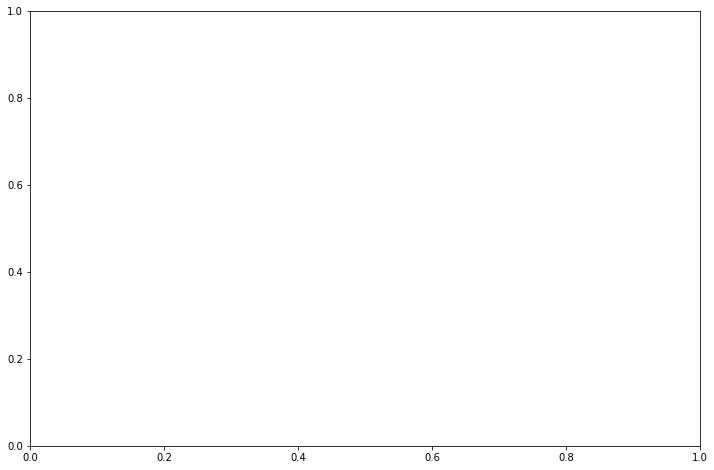

In [13]:
# gpt2 = GPT2Model.from_pretrained('gpt2-xl')
# pangu = AutoModelForCausalLM.from_pretrained("imone/pangu_2_6B", trust_remote_code=True)
# erlangshen = MegatronBertModel.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")

# model_names = ['GPT2-xl', 'pangu', 'erlangshen']
# model_lst = [gpt2, pangu, erlangshen]

gpt2 = GPT2Model.from_pretrained('gpt2')
model_names = ['GPT2-xl']
model_lst = [gpt2]

sparsity = [0, 0.1, 0.5, 0.9, 0.95, 0.99] 

model_size_dic = dict()

print("Start sparsifying...")
for model, model_name in zip(model_lst, model_names):
  for prune_proportion in sparsity:
    target_model = copy.deepcopy(model)
    if sparsity != 0:
      target_model = prune_model(target_model, model_name, prune_proportion)
    model_size_dic[f'{model_name}_sparsity_{prune_proportion*100}%'] = get_model_size(target_model)
    get_params_plot(target_model, model_name, prune_proportion)
    target_model.save_pretrained("{}/models/{}_sparsity_{}".format(os.getcwd(), 
                                                            model_name,
                                                            prune_proportion*100,
                                                            ))
    print("model {} with sparsity {} saved".format(model_name, prune_proportion * 100))
    
print("Sparsification completed!")


In [18]:
dir_open = open(f'{os.getcwd()}/model_size.json', "w")
json.dump(model_size_dic, dir_open, indent = 4)

In [ ]:
# tokenizer = BertTokenizer.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")
# config = MegatronBertConfig.from_pretrained("IDEA-CCNL/Erlangshen-MegatronBert-1.3B")

# Evaluation on Benchmarks

For GPT2: XNLI and CLM

For pangu, erlangshen: XNLI and CLUE